## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')
i = 0

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    draw_img = np.copy(img)

    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(draw_img, (9,6), corners, ret)        
        
        #cv2.waitKey(500)
        
#cv2.destroyAllWindows()


## And so on and so forth...

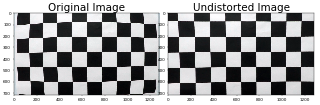

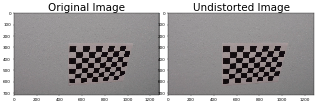

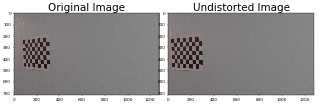

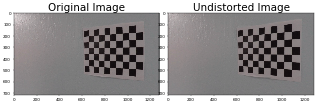

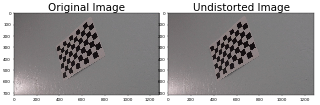

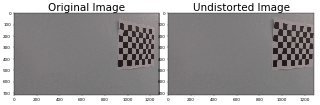

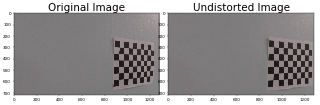

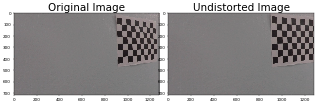

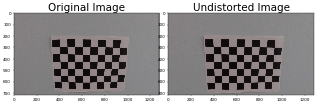

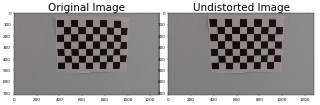

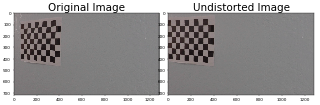

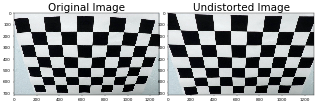

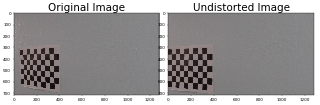

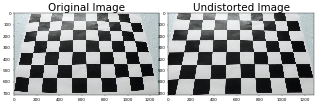

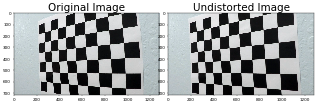

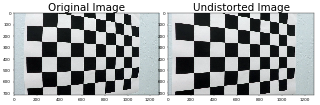

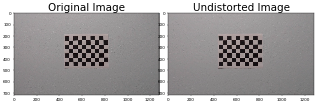

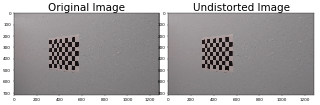

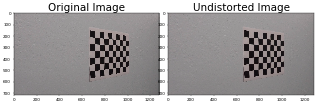

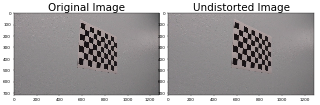

In [2]:
i = 0
for fname in images:
    img = cv2.imread(fname)
    draw_img = np.copy(img)
    
    i += 1
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (img.shape[0], img.shape[1]), None, None)
    # Use cv2.calibrateCamera and cv2.undistort()
    dest = cv2.undistort(img, mtx, dist, None, mtx)
    path = '../output_images/Undistorted_Images/Undistortion'+str(i)+'.jpg'

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), dpi=30)
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=25)
    ax2.set_title('Undistorted Image', fontsize=25)
    ax2.imshow(dest)
    plt.subplots_adjust(left=0., right=0.5, top=0.5, bottom=0.)
    
    plt.savefig(path)

In [3]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

In [4]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

In [5]:
def abs_sobel_thresh(img, orient='x', sobel_kernel = 3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

In [15]:
def pipeline(img, s_thresh=(100, 255), sx_thresh=(100, 255)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    ksize = 3
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    
    #sxbinary = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(100, 255))
    #grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(150, 255))
    #mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(150, 255))
    #dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.7, 1.3))
    combined = np.zeros_like(s_binary)
    #combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (s_binary == 1)] = 1
    combined[(sxbinary == 1) | (s_binary == 1)] = 1

    #color_binary = np.dstack(( np.zeros_like(s_binary), sxbinary, s_binary))
    
    return combined
    
def main_pipeline(image):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (image.shape[0], image.shape[1]), None, None)
    #Use cv2.calibrateCamera and cv2.undistort()
    dest = cv2.undistort(image, mtx, dist, None, mtx)
    result = pipeline(dest)
    
    result_size = result.shape[::-1]
    
    src = np.float32([[585, 460], [700, 460], [1050, 700], [240, 700]])
    dst = np.float32([[300, 0], [900, 0], [900, 720], [300, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    binary_warped = cv2.warpPerspective(result, M, (result.shape[1], result.shape[0]), flags = cv2.INTER_NEAREST)
    warped = cv2.warpPerspective(image, M, (result.shape[1], result.shape[0]), flags = cv2.INTER_NEAREST)
    binary_warped = binary_warped.astype(np.uint8)
    
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    img1 = np.copy(out_img)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = int(binary_warped.shape[0]) - (window+1)*window_height
        win_y_high = int(binary_warped.shape[0]) - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, int(binary_warped.shape[0])-1, int(binary_warped.shape[0]))
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    #plt.imshow(out_img)
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)
    
    #ax5.plot(left_fitx, ploty, color='yellow')
    #ax5.plot(right_fitx, ploty, color='yellow')
    #ax5.xlim(0, 1280)
    #ax5.ylim(720, 0)
    
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    print(left_curverad, right_curverad)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension

    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    
    warped = np.copy(binary_warped)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    warped_back = cv2.addWeighted(dest, 1, newwarp, 0.3, 0)
    #plt.imshow(result)
    
    
    
    # Plot the result
    f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(24, 9))
    f.tight_layout()
    
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=40)

    ax2.imshow(warped_back)
    ax2.set_title('Undistorted Image', fontsize=40)
    
    ax3.imshow(result, cmap='gray')
    ax3.set_title('Binary Image', fontsize=40)
    
    ax4.imshow(binary_warped, cmap='gray')
    #ax4.imshow(warped)
    ax4.set_title('Warped Image', fontsize=40)
    
    ax5.imshow(out_img)
    ax5.set_title('Output Image', fontsize=40)
    #ax5.plot(left_fitx, ploty, color='yellow')
    #ax5.plot(right_fitx, ploty, color='yellow')
    
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    return warped_back

7742.59100064 3042.52479707
2543.08060876 m 999.323598317 m
841.242967514 2253.76121039
242.592736841 m 682.60641369 m


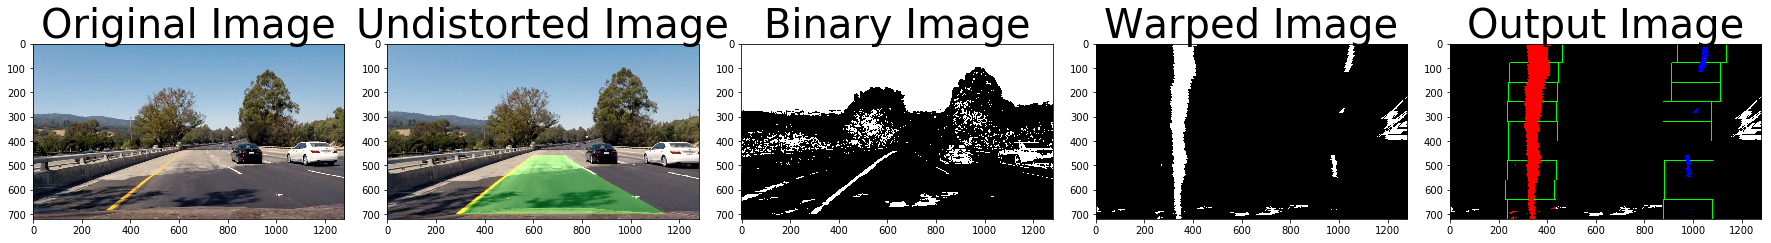

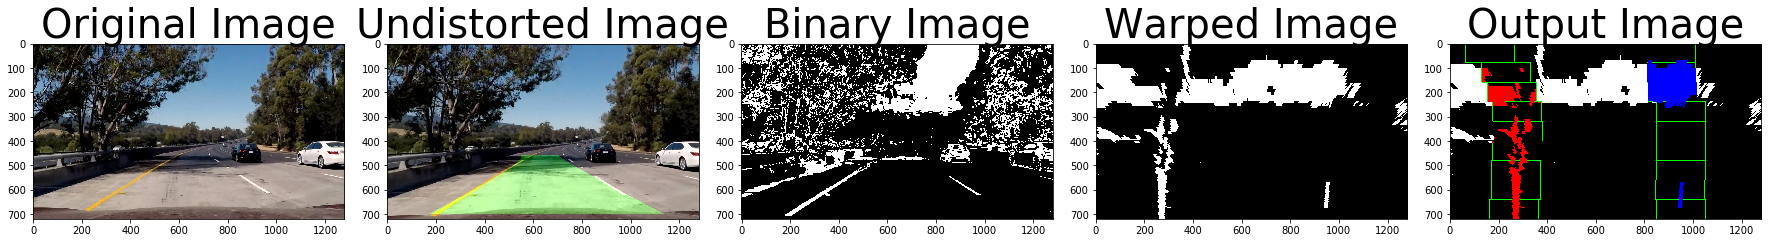

In [17]:
i = 0
raw_images = glob.glob('../test_images/*.jpg')
raw_images = raw_images[5:7]
for fname in raw_images:
    image = mpimg.imread(fname)
    main_pipeline(image)

In [ ]:
class Line():

    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        # x values of the last n fits of the line
        self.recent_xfitted = []
        # average x values of the fitted line over the last n iterations
        self.bestx = None
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        # polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        # radius of curvature of the line in some units
        self.radius_of_curvature = None
        # distance in meters of vehicle center from the line
        self.line_base_pos = None
        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0, 0, 0], dtype='float')
        # x values for detected line pixels
        self.allx = None
        # y values for detected line pixels
        self.ally = None

Left = Line()
Right = Line()

In [ ]:
def process_image(img):
    
    alpha = 0.8

    # Pre-process the image to get an undistored, thresholded, binary, perspective
    # transformed image
    binary_warped = pre_process_image(img, M, mtx, dist)

    # Fit left and right lines
    if (Left.detected == False) or (Right.detected == False):
        Left.current_fit, Right.current_fit = compute_left_and_right_fit(
            binary_warped)
    else:
        Left.current_fit, Right.current_fit = compute_left_and_right_fit(binary_warped,
                                                                         Left.best_fit, Right.best_fit,
                                                                         False, False)

    # Smooth and process lines
    #
    
    yvals = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])

    # Process left line
    if Left.current_fit != None:
    
        if Left.best_fit == None:
            Left.best_fit = Left.current_fit
        
        # Smooth the xvals over previous fit and current-fit
        current_leftx = Left.current_fit[
            0] * yvals**2 + Left.current_fit[1] * yvals + Left.current_fit[2]
        last_leftx = Left.best_fit[0] * yvals**2 + \
            Left.best_fit[1] * yvals + Left.best_fit[2] 
            
        # Update the x based on the moving average
        leftx = (alpha*last_leftx) + (1 - alpha)*current_leftx
        
        # Recompute the best fit coefficients
        Left.best_fit = np.polyfit(yvals, leftx, 2)
        
        # Found left lane
        Left.detected = True
    else:
        Left.detected = False

    # Process right line
    if Right.current_fit != None:
        
        if Right.best_fit == None:
            Right.best_fit = Right.current_fit
            
        # Smooth the xvals over previous fit and current-fit   
        current_rightx = Right.current_fit[
            0] * yvals**2 + Right.current_fit[1] * yvals + Right.current_fit[2]
        last_rightx = Right.best_fit[0] * yvals**2 + \
            Right.best_fit[1] * yvals + Right.best_fit[2]
            
        # Update the x based on the moving average
        rightx = (alpha*last_rightx) + (1 - alpha)*current_rightx
        
        # Recompute the best fit coefficients
        Right.best_fit = np.polyfit(yvals, rightx, 2)
        
        # Found Right line
        Right.detected = True
    else:
        Right.detected = False

    # Compute curvature, draw lane boundaries and warp back to orignial image
    result, Left.radius_of_curvature, Right.radius_of_curvature, offset_from_center = build_result_image(
        binary_warped,
        img,
        Left.best_fit,
        Right.best_fit,
        Minv)
    # Print radius of curvature on video
    cv2.putText(result, 'Radius of Curvature {}(m)'.format(int((Left.radius_of_curvature + Right.radius_of_curvature) / 2)), (120, 140),
                fontFace=16, fontScale=2, color=(255, 255, 255), thickness=2)

    # Print distance from center on video
    if offset_from_center < 0:
        cv2.putText(result, 'Vehicle is {:.2f}m left of center'.format(abs(offset_from_center)), (100, 80),
                    fontFace=16, fontScale=2, color=(255, 255, 255), thickness=2)
    else:
        cv2.putText(result, 'Vehicle is {:.2f}m right of center'.format(offset_from_center), (100, 80),
                    fontFace=16, fontScale=2, color=(255, 255, 255), thickness=2)

    # Return result image
    return result

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
white_output = 'sampling.mp4'
clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image(main_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)